In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2


In [2]:

from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from matplotlib.patches import Circle
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
from matplotlib.colors import LogNorm
from StringIO import StringIO
import datetime
import scipy.ndimage as ndimage
from astropy import units as u
from astropy import cosmology
from astropy.cosmology import WMAP5, Planck15
MetalFlag=0

In [3]:
path = "/data/OWN/SF1test/SF0/mstar1_T3600/output_00041"
name = "MochimaSF0"
myhalo= wkbl.Galaxy_Hound(path)
print "loaded"
zoom_reg = np.where(myhalo.dm.mass==myhalo.dm.mass.min())
nucenter = nbe.real_center(myhalo.dm.pos3d[zoom_reg], myhalo.dm.mass[zoom_reg])
myhalo.center_shift(nucenter)
myhalo.r_virial(600)
print "cutted"

myhalo.redefine(4.5)

loading Dark matter..
loading Stars..
loading Gas..
loaded


/home/arturo/Documents/git/WKBL/wkbl/astro/galaxy_peeker.py:74: RuntimeWarning: divide by zero encountered in divide
  rho_s = np.cumsum(mhist) / vol_bin
/home/arturo/Documents/git/WKBL/wkbl/astro/_dark_matter.py:67: RuntimeWarning: invalid value encountered in arccos
  self.theta = np.arccos(np.copy(self.pos3d[:,0]),np.copy(self.r))
/home/arturo/Documents/git/WKBL/wkbl/astro/_stars.py:59: RuntimeWarning: invalid value encountered in arccos
  self.theta = np.arccos(np.copy(self.pos3d[:,0]),np.copy(self.r))


| r_200 = 212.70
| Diagonal matrix computed 
|    | 20, 0, 0|
| D =| 0, 14, 0|
|    | 0,  0, 4|
cutted


In [38]:
ok,myhalo.dm.rho,_= CF.getDensity(np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),
                                    dtype=np.float32), myhalo.dm.mass)


In [39]:
ok,myhalo.st.rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),
                                    dtype=np.float32), myhalo.st.mass)

In [40]:
myhalo.r200

212.6953125

<IPython.core.display.Javascript object>


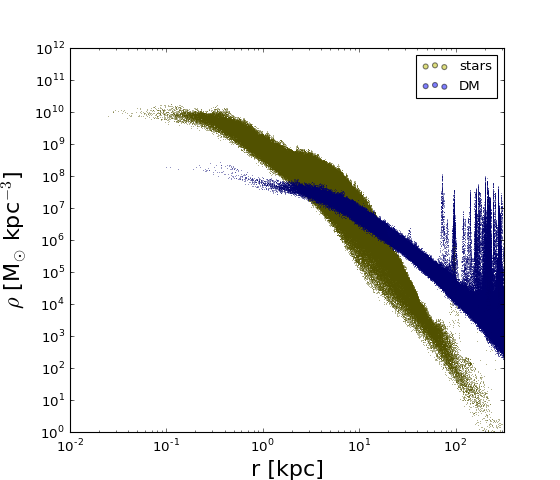

/usr/lib/python2.7/dist-packages/matplotlib/legend.py:325: UserWarning: Unrecognized location "bottom left". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  six.iterkeys(self.codes))))


In [41]:
fig, ax= plt.subplots(figsize=[7,6])
ax.set_xlim([1e-2,10**2.5])
ax.set_ylim([1,1e12])
ax.scatter(myhalo.st.r, myhalo.st.rho,s=0.5,alpha=0.5,lw=0,c='y')
ax.scatter(1e20,1e20,c='y',alpha=0.5, label="stars")
ax.scatter(1e20,1e20,c='b',alpha=0.5, label="DM")

ax.scatter(myhalo.dm.r, myhalo.dm.rho,s=0.5,alpha=0.5,lw=0)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e0,1e12])
ax.set_xlabel(r"r [kpc]",fontsize=20)
ax.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)
####
legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)

In [42]:
def face_on_dm(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.dm.pos3d[:,0], 
                                       sim.dm.pos3d[:,1],
                                       bins=(edges, edges),
                                       weights=sim.dm.mass)
    result = H.T
    return result, edges

def face_on_st(sim,lims,points,thikness=.5):
    disk = (np.abs(sim.st.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[disk,0], 
                                       sim.st.pos3d[disk,1],
                                       bins=(edges, edges),
                                       weights=sim.st.mass[disk])
    result = H.T
    return result, edges

def face_on_gs(sim,lims,points,thikness=.9):
    disk = (np.abs(sim.gs.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[disk,0], 
                                       sim.gs.pos3d[disk,1],
                                       bins=(edges, edges),
                                       weights=sim.gs.mass[disk])
    result = H.T
    return result, edges

def edge_on_st(sim,lims,points):
    #disk = sim.st.pos3d[:,2]
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[:,0], 
                                       sim.st.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=sim.st.mass)
    result = H.T
    return result, edges
    
def edge_on_gs(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[:,0], 
                                       sim.gs.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=sim.gs.mass)
    result = H.T
    return result, edges
    

In [43]:
# Moster et all
def M_1(z):
    M10 ,M11 = 11.590, 1.195
    log = M10 + M11*(z / (z+1))
    return 10**(log)

def N(z):
    N10 ,N11 = 0.0351, -0.0247
    return N10 + N11*(z / (z+1))


def beta(z):
    B10 ,B11 = 1.376, -0.826
    return B10 + B11*(z / (z+1))


def gamma(z):
    G10 ,G11 = 0.608, 0.329
    return G10 + G11*(z / (z+1))

def mm(M,z=0):
    one = ( M / M_1(z))**(-beta(z))
    two = ( M / M_1(z))**gamma(z)
    return 2*N(z) * M / (one +two)

def alpha(m):
    return 0.15 / np.log10(m)

M = np.logspace(10,14,50)
m = mm(M)
al = np.sqrt(m)#alpha(m)

<IPython.core.display.Javascript object>


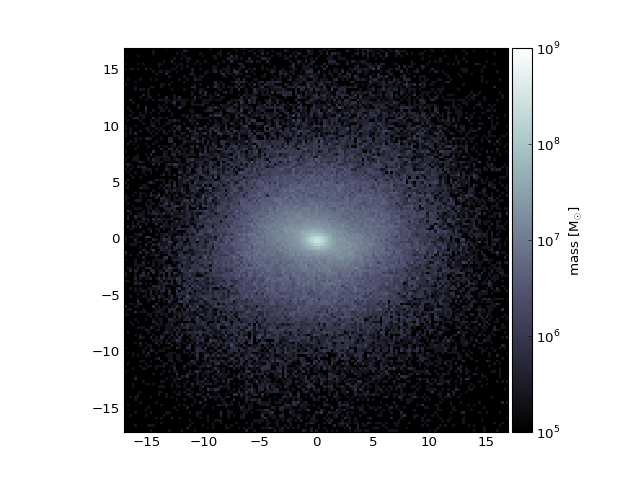

In [44]:
fig, ax = plt.subplots()
length = 17
SF1140_faceOn,edges = face_on_st(myhalo,[-length,length],150)#H.T 

mass_2 = ax.imshow(SF1140_faceOn+1e2,interpolation='nearest', origin='low',cmap="bone",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=1e9)
                  )

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

<IPython.core.display.Javascript object>


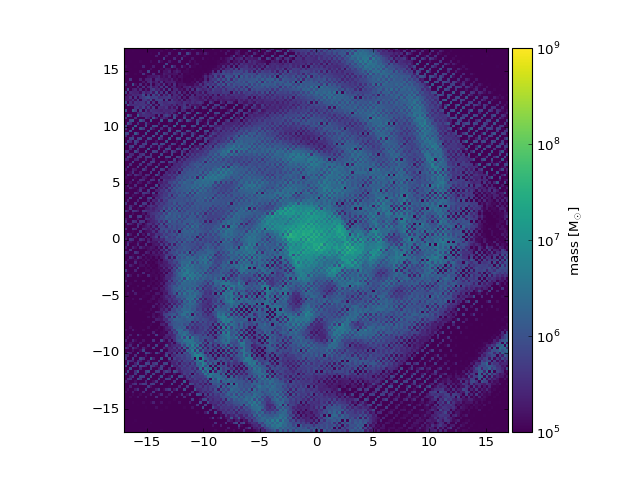

In [45]:
fig, ax = plt.subplots()
SF1140_faceOn,edges= face_on_gs(myhalo,[-length,length],150)#H.T 

mass_2 = ax.imshow(SF1140_faceOn+1e5, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=1e9)
                  )

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

<IPython.core.display.Javascript object>


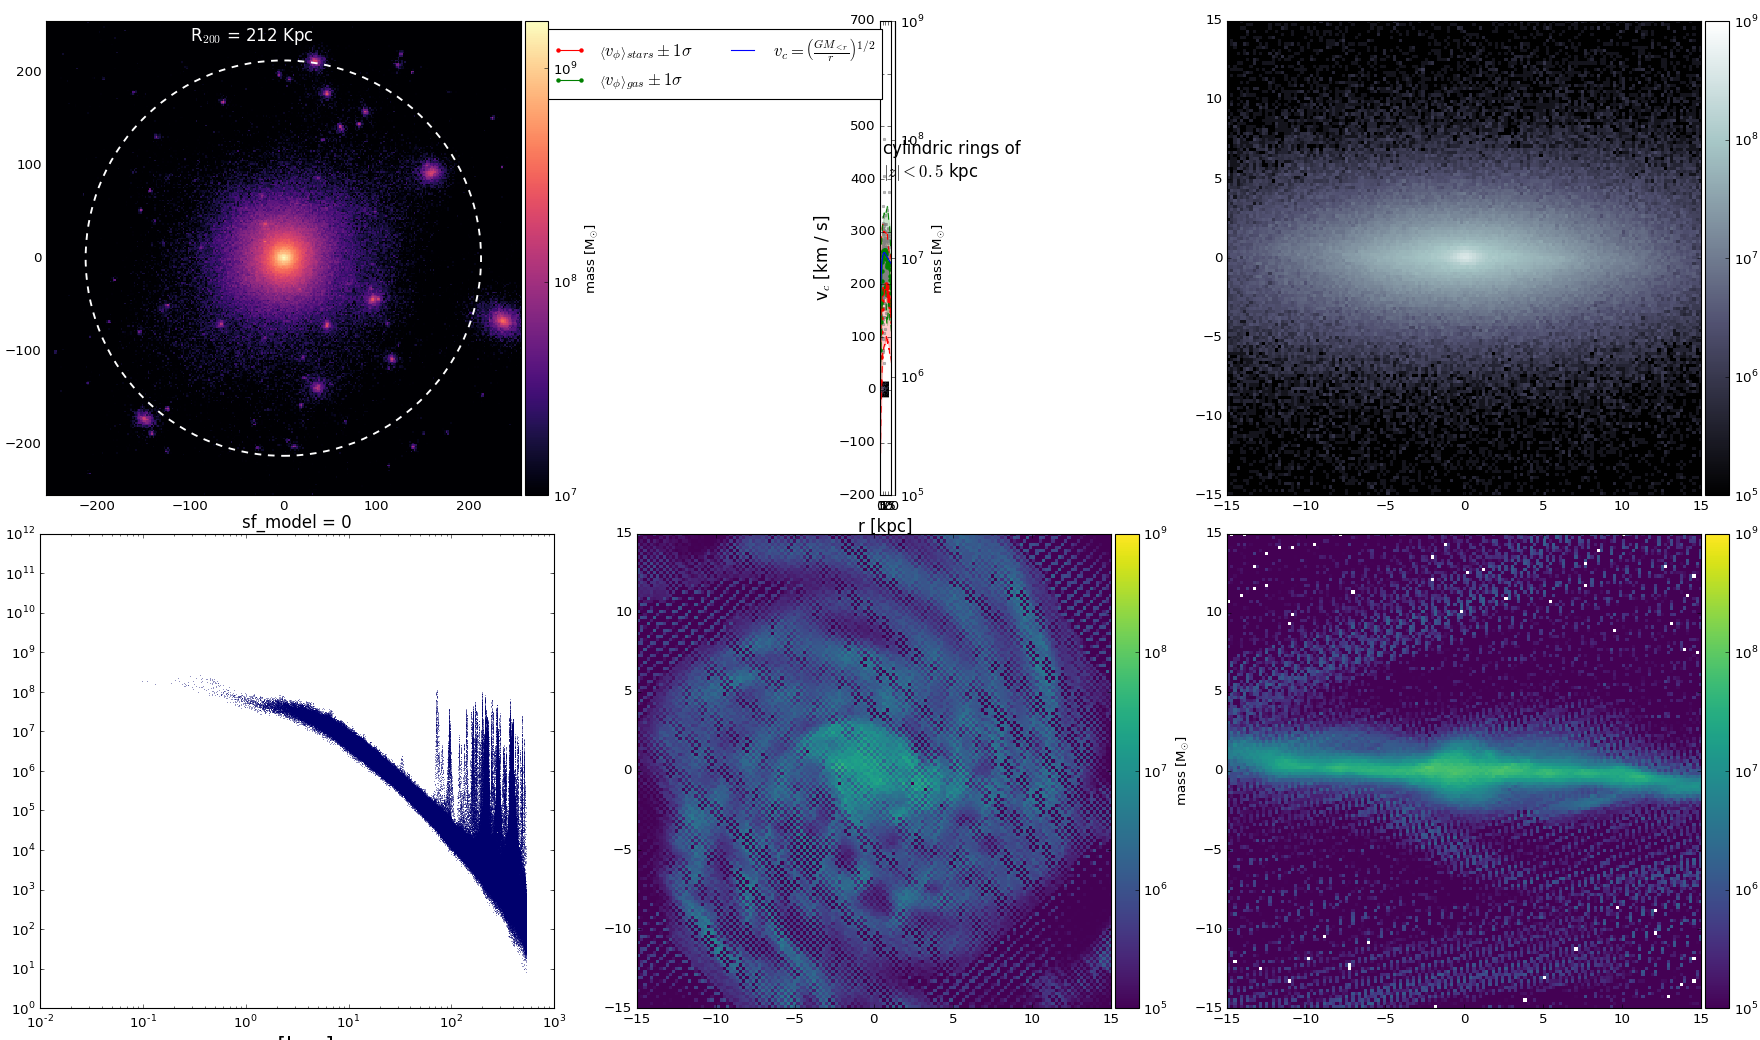

In [46]:

SF130_faceon, edges = face_on_dm(myhalo,[-1.2*myhalo.r200,1.2*myhalo.r200],300)
length = 15. 
fig,[[ax,ax1,ax2],[ax3,ax4,ax5]] = plt.subplots(2,3,figsize=[22,13])
fig.tight_layout(w_pad=3)

#######################################################################################################################3
mass_1 = ax.imshow(SF130_faceon+1e3, interpolation='nearest', origin='low',cmap="magma",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e7)
                  )
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')

ax.add_artist(Circle(xy=(0, 0),radius=myhalo.r200,color='w',ls='--',lw=1.7,fill=False))
ax.text(-100,1.1*myhalo.r200,r"R$_{200}$ = "+str(int(myhalo.r200))+" Kpc ",color='w',fontsize=15)
#######################################################################################################################3

SF1140_faceOn,edges = face_on_st(myhalo,[-length,length],200)#H.T 

mass_2 = ax1.imshow(SF1140_faceOn+1e2,interpolation='nearest', origin='low',cmap="bone",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=1e9)
                  )

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
#######################################################################################################################3

SF1140_edgeOn,edges = edge_on_st(myhalo,[-length,length],150)#H.T 


mass_2 = ax2.imshow(SF1140_edgeOn+1e3, interpolation='nearest', origin='low',cmap="bone",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=1e9)
                  )

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

SF1140_faceOn,edges= face_on_gs(myhalo,[-length,length],150)#H.T 

mass_2 = ax4.imshow(SF1140_faceOn+1e5, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=1e9)
                  )

divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

#######################################################################################################################3

SF1140_edgeOn,edges = edge_on_gs(myhalo,[-length,length],150)#H.T 


mass_2 = ax5.imshow(SF1140_edgeOn, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=1e9)
                  )

divider = make_axes_locatable(ax5)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')


ax3.scatter(myhalo.dm.r, myhalo.dm.rho,s=0.5,alpha=0.5,lw=0)
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_ylim([1e0,1e12])
ax3.set_xlabel(r"r [kpc]",fontsize=20)
ax3.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)
ax3.set_title("sf_model = 0",fontsize=15)

<IPython.core.display.Javascript object>


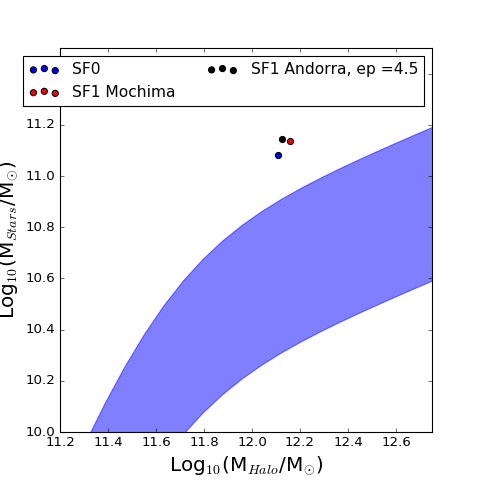

In [47]:
fig, ax = plt.subplots(figsize = [6,6])
ax.set_xlim(11.2,12.75)
ax.set_ylim(10,11.5)
ax.set_xlabel(r'Log$_{10}$(M$_{Halo}$/M$_{\odot}$)',fontsize=18)
ax.set_ylabel(r'Log$_{10}$(M$_{Stars}$/M$_{\odot}$)',fontsize=18)

ax.fill_between(np.log10(M), np.log10(m)+.3,np.log10(m)-.3,color='blue',alpha=0.5 )
x = 0.03
y = -.02
#ax.scatter(np.log10(SF1_30.dm.total_m),np.log10(SF1_30.st.total_m),marker='s',c='r',s=30)
#ax.text(np.log10(SF1_30.dm.total_m)+x,np.log10(SF1_30.st.total_m)+y,'30 Myr',fontsize=13)
#ax.scatter(np.log10(SF1_90.dm.total_m),np.log10(SF1_90.st.total_m),marker='^',c='g',s=30)
#ax.text(np.log10(SF1_90.dm.total_m)+x,np.log10(SF1_90.st.total_m)+y,'90 Myr',fontsize=13)
ax.scatter(np.log10(myhalo.dm.total_m),np.log10(myhalo.st.total_m),marker='o',c='b',s=30,label='SF0')
ax.scatter(12.158, 11.1386,marker='o',c='r',s=30,label='SF1 Mochima')
ax.scatter(12.1239, 11.1429,marker='o',c='k',s=30,label='SF1 Andorra, ep =4.5')

#ax.text(np.log10(myhalo.dm.total_m)+x,np.log10(myhalo.st.total_m)+y,'140 Myr',fontsize=13)
#ax.scatter(np.log10(SF0.dm.total_m),np.log10(SF0.st.total_m),marker='>',c='m',s=30)
#ax.text(np.log10(SF0.dm.total_m)+x,np.log10(SF0.st.total_m)+y,'Old Star Formation',fontsize=13)

legend = ax.legend(loc='upper right', ncol=2, shadow=False, fontsize=14)
frame = legend.get_frame()

In [48]:
r_arr = np.arange(0,30,30./100.)
_= np.histogram(myhalo.dm.r,bins=r_arr,weights=myhalo.dm.vtheta)



In [5]:

pos_dm = np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(myhalo.gs.pos3d.reshape(len(myhalo.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st, pos_gs))
mass = np.concatenate((myhalo.dm.mass,myhalo.st.mass,myhalo.gs.mass))
v = np.concatenate((myhalo.dm.v,myhalo.st.v,myhalo.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

9749007 9749007


In [6]:

def circular_speed(r,comp="all"):
    if comp=='all': 
        m = mass
        radii = np.sqrt(r2)
    elif comp=="dm":
        m = myhalo.dm.mass
        radii = myhalo.dm.r
    elif comp=="st":
        m = myhalo.st.mass
        radii = myhalo.st.r
    elif comp=="gs":
        m = myhalo.gs.mass
        radii = myhalo.gs.r
    else:
        sys.exit("no valid component")
    enclosed_m = np.sum(m[np.where(radii<r)])
    return np.sqrt(myhalo.p.G * enclosed_m / r) * myhalo.p.kpctokm

get_vc= np.vectorize(circular_speed)
r = np.linspace(0,40,60)
vc_all = get_vc(r,comp='all')
vc_dm = get_vc(r,comp='dm')
vc_st = get_vc(r,comp='st')
vc_gs = get_vc(r,comp='gs')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [7]:
vc_stars_vphi = np.array([])
std_stars_vphi = np.array([])
vc_gas_vphi = np.array([])
std_gas_vphi = np.array([])
for i in range(len(r)-1):
    stars_condition = (myhalo.st.R>r[i])&(myhalo.st.R<r[i+1])&(np.abs(myhalo.st.pos3d[:,2])<0.5)
    gas_condition = (myhalo.gs.R>r[i])&(myhalo.gs.R<r[i+1])&(np.abs(myhalo.gs.pos3d[:,2])<0.5)
    vc_gas_vphi = np.append(vc_gas_vphi, np.average(myhalo.gs.vphi[gas_condition]))
    std_gas_vphi = np.append(std_gas_vphi, np.std(myhalo.gs.vphi[gas_condition]))
    #for stars
    vc_stars_vphi = np.append(vc_stars_vphi, np.nanmean(myhalo.st.vphi[stars_condition]))
    std_stars_vphi = np.append(std_stars_vphi, np.nanstd(myhalo.st.vphi[stars_condition]))
r_arrays = (r[1:] + r[:-1]) / 2.

In [8]:
file = open("../vcdata.dat")
R_mw = np.array([])
R_err = np.array([])
vc_mw = np.array([])
vc_err = np.array([])

for ln in file:
    row = ln.split('\t')
    if row[0][0]=='#':
        continue
    R_mw = np.append(R_mw, row[0])
    R_err = np.append(R_err, row[1])
    vc_mw = np.append(vc_mw, row[2])
    vc_err = np.append(vc_err, row[3])
print vc_err    

['4.5' '4.5' '4.5' ... '19.8466566348' '19.7816973913' '23.7338181969']


<IPython.core.display.Javascript object>


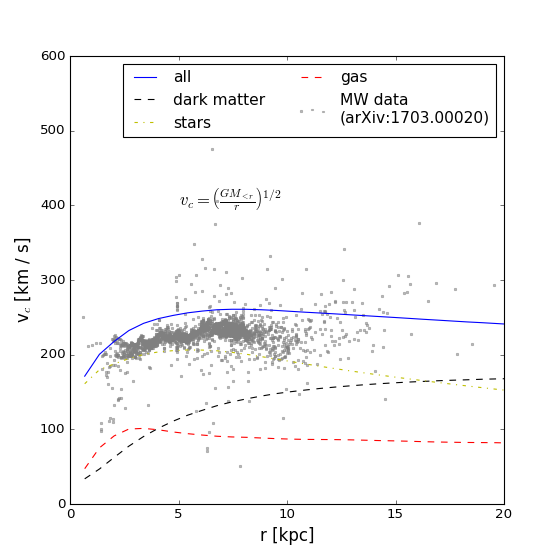

2590 2590


In [12]:
fig, ax = plt.subplots(figsize=[7,7])
ax.set_ylim(0,600)
ax.set_xlim(0,20)


print len(vc_mw),len(vc_err)
ax.scatter(R_mw,vc_mw,color='gray',marker='s',alpha=0.5,s=2,label="MW data\n(arXiv:1703.00020)")
ax.plot(r, vc_all,'b-',label='all')
ax.plot(r, vc_dm, 'k--',label='dark matter')
ax.plot(r, vc_st, 'y-.',label='stars')
ax.plot(r, vc_gs ,'r--',label='gas')
texto  = r"$v_c = \left(\frac{G M_{<r}}{r}\right)^{1/2}$"
ax.text(5,400,texto,fontsize=15)
ax.set_xlabel("r [kpc]",fontsize=15)
ax.set_ylabel(r"v$_{c}$ [km / s]",fontsize=15)
legend = ax.legend(loc='upper right', ncol=2, shadow=False, fontsize=14)
frame = legend.get_frame()

#plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/report07-17/HaloB/circularSpeedsCilyndric.pdf")

In [54]:
nml  = open(path+'/namelist.txt')
for l in nml:
    row=l.split('=')
    if row[0]=='sf_model':sf=row[1]
output = open('../../../datafiles/'+name+'_rotcurv.dat','w')
output.write("# rot_curv for "+name+ "\n")
output.write("# sf_model = "+sf+", hsml = "+str(myhalo.gs.hsml.min())+"\n")
output.write("# format\n")
output.write("# r , vc_stars, vc_dm, vc_gas, vc_all\n")

for i in range(1,len(vc_all)):
    output.write("{0:.3f}, {1:.3f}, {2:.3f}, {3:.3f}, {4:.3f} \n".format(r[i], vc_st[i], vc_dm[i], vc_gs[i], vc_all[i]))

output.close()

In [31]:
# total stellar mass inside 0.1*r97
Mstar = np.sum(myhalo.st.mass[myhalo.st.r < (myhalo.r97/10.)])
# wheighted histogram of mass as the radius grows
hist = np.histogram(myhalo.st.r[myhalo.st.r < (myhalo.r97/10.)],bins=5012,
             weights=myhalo.st.mass[myhalo.st.r < (myhalo.r97/10.)])
# find radius wher 80% of the stellar mass is contained
"""
note that this radius is decided like that by mollitor because
in his sim the rotatioon curve are already flat, in our case this does
not happens..
"""
r_80 = hist[1][np.argmin(np.abs((np.cumsum(hist[0])/hist[0].sum())-0.8))]
# circular speed
v_rot = circular_speed(r_80)

<IPython.core.display.Javascript object>


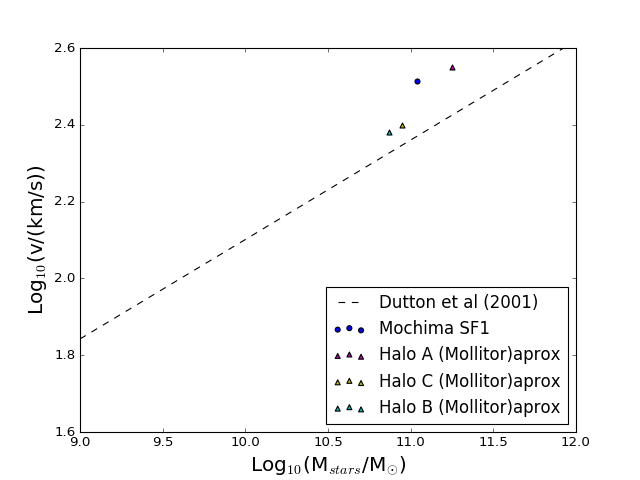

In [33]:
Sf1_x, Sf1_y =11.0904, 2.5110828926
fig, ax = plt.subplots()
ax.set_xlim(9,12)
ax.set_ylim(1.6,2.6)
ax.set_xlabel(r"Log$_{10}$(M$_{stars}$/M$_{\odot}$)",fontsize=18)
ax.set_ylabel(r"Log$_{10}$(v/(km/s))",fontsize=18)
x = np.arange(9.,14,0.2)
ax.plot(x, 2.179+(x-10.3)*0.259,"k--",label="Dutton et al (2001)")
ax.scatter(np.log10(Mstar),np.log10(v_rot),label="Mochima SF1")


ax.scatter(11.25,2.55,color="m",marker="^",edgecolor="k",label="Halo A (Mollitor)aprox")
ax.scatter(10.95,2.4,color="y",marker="^",edgecolor="k",label="Halo C (Mollitor)aprox")
ax.scatter(10.87,2.38,color="c",marker="^",edgecolor="k",label="Halo B (Mollitor)aprox")
legend = ax.legend(loc='lower right', ncol=1, shadow=False, fontsize=15)
frame = legend.get_frame()



<IPython.core.display.Javascript object>


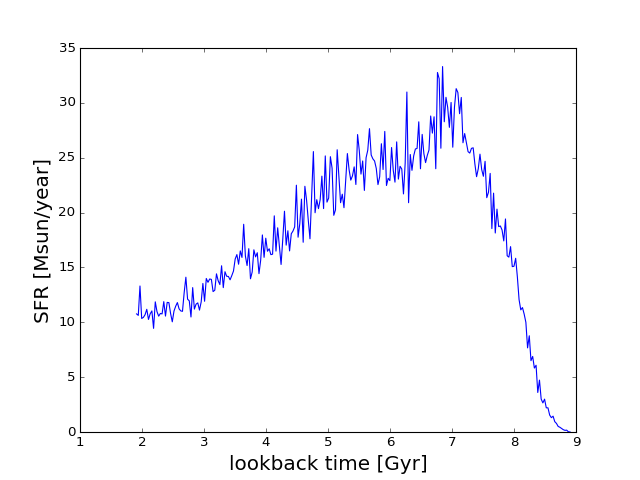

In [34]:
age_hist = np.histogram(myhalo.st.age,bins=256,weights=myhalo.st.mass)
fig,ax = plt.subplots()
ax.set_ylim([0,35])
ax.set_ylabel("SFR [Msun/year]", fontsize=18)
ax.set_xlabel("lookback time [Gyr]", fontsize=18)
thikness=age_hist[1][1]-age_hist[1][0]

ax.plot(-1*age_hist[1][:-1],age_hist[0]/(thikness*1e9))


In [35]:
print len(myhalo.dm.r[(myhalo.dm.r<7.4)&(myhalo.dm.r>7.5)])

0


<IPython.core.display.Javascript object>


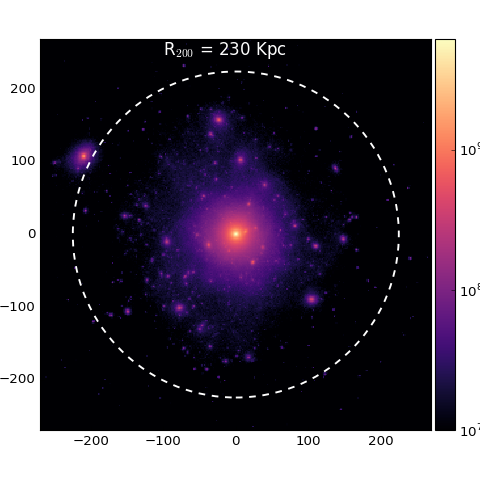

In [36]:

SF130_faceon, edges = face_on_dm(myhalo,[-1.2*myhalo.r200,1.2*myhalo.r200],300)
length = 15. 
fig,ax = plt.subplots(figsize=[6,6])
fig.tight_layout(w_pad=3)

#######################################################################################################################3
mass_1 = ax.imshow(SF130_faceon+1e3, interpolation='nearest', origin='low',cmap="magma",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e7)
                  )
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')

ax.add_artist(Circle(xy=(0, 0),radius=myhalo.r200,color='w',ls='--',lw=1.7,fill=False))
ax.text(-100,1.1*myhalo.r200,r"R$_{200}$ = 230 Kpc ",color='w',fontsize=15)

In [40]:
MagMet=MagAge=MagU=MagB=MagV=MagR=MagI=MagJ=MagH=MagK=np.array([0])

with open('../luminosityFiles/NoObscuration.txt') as maginfo:
        for line in maginfo:
             #print(line)

             result=np.genfromtxt(StringIO(line),comments='#',delimiter=None)
             #magage=np.append(magage,result[0])
             #print result
             if len(result)>0:
                 MagMet=np.append(MagMet,result[0])
                 MagAge=np.append(MagAge,result[1])
                 MagU=np.append(MagU,result[3])
                 MagB=np.append(MagB,result[4])
                 MagV=np.append(MagV,result[5])
                 MagR=np.append(MagR,result[6])
                 MagI=np.append(MagI,result[7])
                 MagJ=np.append(MagJ,result[8])
                 MagH=np.append(MagH,result[9])
                 MagK=np.append(MagK,result[10])
MagMet=MagMet[1:]
MagAge=-MagAge[1:]/1e9
MagU=MagU[1:]
MagB=MagB[1:]
MagV=MagV[1:]
MagR=MagR[1:]
MagI=MagI[1:]
MagJ=MagJ[1:]
MagH=MagH[1:]
MagK=MagK[1:]


In [41]:
def MagCalc(Mag_band,SolMagBand):
    def the_func(metal,age,mass):
        #Select first 2 matrices by metal...
        selection = np.where(abs(metal-MagMet)<=abs(metal-MagMet).min())
        MagAgeSelected=MagAge[selection]
        MagSelected=Mag_band[selection]
        #...then search for the closest star age in the selected list
        ind=np.argmin(abs(age-MagAgeSelected))
        #Calculate Bolometric Magnitude
        mag=MagSelected[ind]-2.5*np.log10(mass)
        #Calculate 
        lum=10**((SolMagBand-mag)/2.5)  #in Solar Luminosities
        return mag,lum
    calculate = np.vectorize(the_func)
    return calculate(myhalo.st.metal, myhalo.st.age, myhalo.st.mass)

In [42]:
magUSun = 5.55
magBSun = 5.45
magVSun = 4.80
magRSun = 4.46
magISun = 4.11
magJSun = 3.67
magHSun = 3.33
magKSun = 3.29

In [43]:
a = datetime.datetime.now()
mag_R,lum_R = MagCalc(MagR,magRSun) 
b = datetime.datetime.now()
print "this took {0}".format(b-a)

this took 0:01:13.340298


In [44]:
a = datetime.datetime.now()
mag_U,lum_U = MagCalc(MagU,magUSun) 
b = datetime.datetime.now()
print "this took {0}".format(b-a)

this took 0:01:11.159451


In [46]:
a = datetime.datetime.now()
mag_B,lum_B = MagCalc(MagB,magBSun) 
b = datetime.datetime.now()
print "this took {0}".format(b-a)

this took 0:01:10.625868


In [48]:
a = datetime.datetime.now()
mag_K,lum_K = MagCalc(MagK,magKSun) 
b = datetime.datetime.now()
print "this took {0}".format(b-a)

this took 0:01:25.669971


In [49]:
def face_on_st_lum(sim,lims,cond,points,lu,thikness=.5):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[cond,0], 
                                       sim.st.pos3d[cond,1],
                                       bins=(edges, edges),
                                       weights=lu[cond])
    result = H.T
    return result, edges

def edge_on_st_lum(sim,lims,cond,points,lu,thikness=.5):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[cond,0], 
                                       sim.st.pos3d[cond,2],
                                       bins=(edges, edges),
                                       weights=lu[cond])
    result = H.T
    return result, edges

In [57]:
ALL = np.array([True for i in myhalo.st.rho])
resolution = 1080
fK, edges = face_on_st_lum(myhalo,[-15,15],ALL,resolution,lum_K)
fB, edges = face_on_st_lum(myhalo,[-15,15],ALL,resolution,lum_B)
fU, edges = face_on_st_lum(myhalo,[-15,15],ALL,resolution,lum_U)
eK, edges = edge_on_st_lum(myhalo,[-15,15],ALL,resolution,lum_K)
eB, edges = edge_on_st_lum(myhalo,[-15,15],ALL,resolution,lum_B)
eU, edges = edge_on_st_lum(myhalo,[-15,15],ALL,resolution,lum_U)

<IPython.core.display.Javascript object>


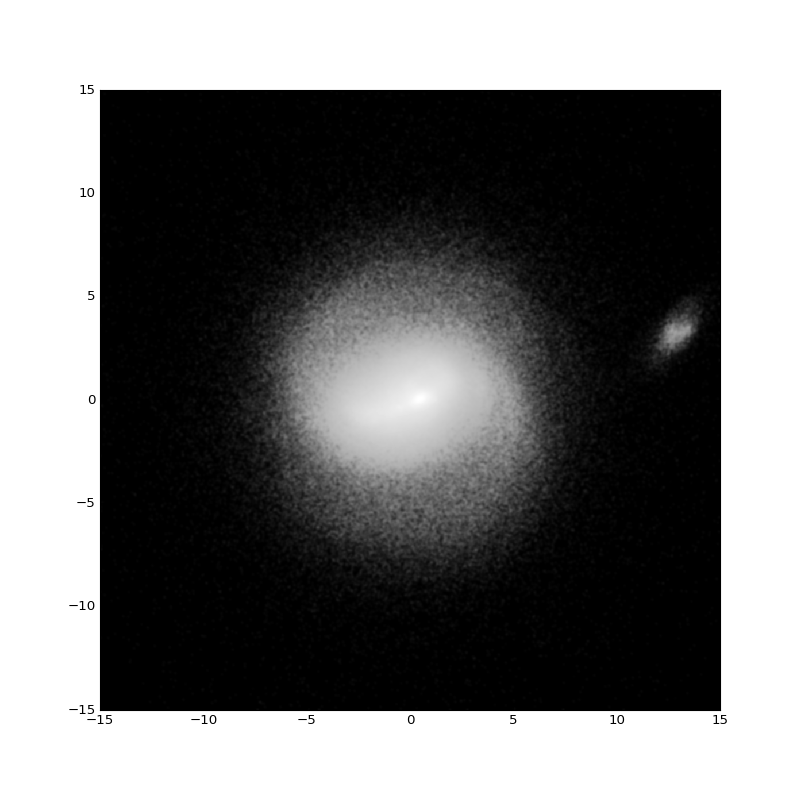

summing


In [60]:
fig, ax1 = plt.subplots(figsize=[10,10])
ax1.patch.set_facecolor("k")
rho_prop , age_lim =0.1, -1
rhomax = rho_prop * np.mean(myhalo.st.rho)
ALL = np.array([True for i in myhalo.st.rho])
condition = (myhalo.st.age<age_lim)
sigma = 1

print "summing"
I = (fK+fB+fU)/3.


#######################################################################################################################3
def func(a):
    m, M=0.8*(np.mean(a)),0.6*(a.max())
    result = np.log(a-m)/np.log(M-m)
    result[np.where(a<m)]=0
    result[np.where(a>M)]=1
    return result

I_factor = func(I)/I
face_K = np.nan_to_num(fK*I_factor)#np.nan_to_num(func(K))#
face_K /= face_K.max()
face_B = np.nan_to_num(fB*I_factor)#np.nan_to_num(func(B))#
face_B /= face_B.max()
face_U = np.nan_to_num(fU*I_factor)#np.nan_to_num(func(U))#
face_U /= face_U.max()
face_Uk = ndimage.gaussian_filter(face_U, sigma=2, order=0)
face_Kk = ndimage.gaussian_filter(face_K, sigma=2, order=0)
face_Bk = ndimage.gaussian_filter(face_B, sigma=2, order=0)

face = face_Kk + face_Bk + face_Uk



mass_1 = ax1.imshow(face, interpolation='none', origin='low',cmap=plt.cm.gist_gray,
                       extent=[edges[0], edges[-1], edges[0], edges[-1]]
                  )